In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json # Para guardar los datos del scaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tf2onnx
import onnx

# Configuración visual
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

print("Librerías cargadas correctamente.")

print("TensorFlow version:", tf.__version__)
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))
tf.test.is_built_with_cuda()





Librerías cargadas correctamente.
TensorFlow version: 2.15.0
GPUs disponibles: []


False

In [2]:
# 1. Cargar el archivo limpio
file_path = 'datos_limpios.csv' 

try:
    df = pd.read_csv(file_path)
    print(f"Datos cargados: {df.shape[0]} filas, {df.shape[1]} columnas")
except FileNotFoundError:
    raise Exception("No se encuentra 'datos_limpios.csv'. Asegúrate de haberlo generado.")

# 2. Separar X (Sensores) e y (Acciones) basándonos en los prefijos
cols_sensores = [c for c in df.columns if c.startswith('S_')]
cols_acciones = [c for c in df.columns if c.startswith('A_')]

X = df[cols_sensores]
y = df[cols_acciones]

print(f"Inputs (Sensores): {X.shape[1]} variables")
print(f"Outputs (Acciones): {y.shape[1]} variables ({list(y.columns)})")

Datos cargados: 256873 filas, 30 columnas
Inputs (Sensores): 27 variables
Outputs (Acciones): 3 variables (['A_Accel', 'A_Gear', 'A_Steer'])


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Dividir datos: 80% para entrenar, 20% para validar
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2. Ajustar el Escalador SOLO con los datos de entrenamiento
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 3. Convertir salidas a NumPy (EVITA errores con Keras multi-output)
y_train = y_train.values
y_test  = y_test.values

print("Datos normalizados y salidas convertidas a NumPy correctamente.")


Datos normalizados y salidas convertidas a NumPy correctamente.



Entrenando...
Epoch 1/50

6422/6422 [==============================] - 44s 5ms/step - loss: 0.1830 - accel_loss: 0.0857 - gear_loss: 0.0845 - steer_loss: 0.0129 - accel_mae: 0.2349 - gear_mae: 0.1316 - steer_mae: 0.0500 - val_loss: 0.0976 - val_accel_loss: 0.0673 - val_gear_loss: 0.0235 - val_steer_loss: 0.0068 - val_accel_mae: 0.2026 - val_gear_mae: 0.0928 - val_steer_mae: 0.0380
Epoch 2/50
6422/6422 [==============================] - 35s 6ms/step - loss: 0.0814 - accel_loss: 0.0566 - gear_loss: 0.0178 - steer_loss: 0.0070 - accel_mae: 0.1806 - gear_mae: 0.0655 - steer_mae: 0.0377 - val_loss: 0.0702 - val_accel_loss: 0.0492 - val_gear_loss: 0.0153 - val_steer_loss: 0.0058 - val_accel_mae: 0.1661 - val_gear_mae: 0.0523 - val_steer_mae: 0.0333
Epoch 3/50
6422/6422 [==============================] - 36s 6ms/step - loss: 0.0660 - accel_loss: 0.0453 - gear_loss: 0.0145 - steer_loss: 0.0062 - accel_mae: 0.1581 - gear_mae: 0.0556 - steer_mae: 0.0350 - val_loss: 0.0590 - val_accel_loss: 0.03

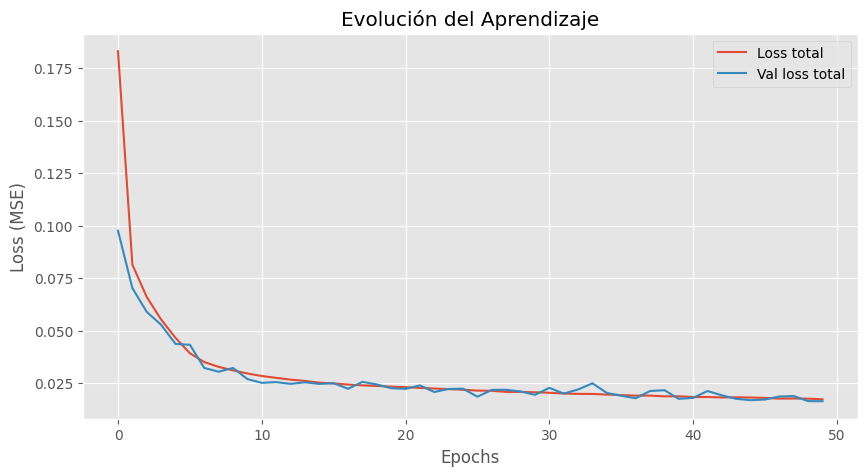

In [4]:
# ============================
# MODELO MULTI-SALIDA INDEPENDIENTE (ACCEL / GEAR / STEER)
# ============================

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1. MAPEO DE FEATURES -> ÍNDICES (AJUSTA SI ES NECESARIO)
# --------------------------------------------------

feature_idx = {
    'S_speed':     X.columns.get_loc('S_speed'),
    'S_rpm':       X.columns.get_loc('S_rpm'),
    'S_gear':      X.columns.get_loc('S_gear'),
    'S_angle':     X.columns.get_loc('S_angle'),
    'S_trackPos':  X.columns.get_loc('S_trackPos'),

    'S_track_3':   X.columns.get_loc('S_track_3'),
    'S_track_4':   X.columns.get_loc('S_track_4'),
    'S_track_7':   X.columns.get_loc('S_track_7'),
    'S_track_8':   X.columns.get_loc('S_track_8'),
    'S_track_9':   X.columns.get_loc('S_track_9'),
    'S_track_10':  X.columns.get_loc('S_track_10'),
    'S_track_13':  X.columns.get_loc('S_track_13'),
    'S_track_14':  X.columns.get_loc('S_track_14'),
    'S_track_15':  X.columns.get_loc('S_track_15'),
}

# --------------------------------------------------
# 2. ENTRADA GLOBAL
# --------------------------------------------------

input_layer = Input(shape=(X_train_scaled.shape[1],))

# --------------------------------------------------
# 3. SUBRED ACCEL
# --------------------------------------------------

accel_features = [
    feature_idx['S_track_9'],
    feature_idx['S_rpm'],
    feature_idx['S_track_10'],
    feature_idx['S_track_8'],
    feature_idx['S_speed'],
    feature_idx['S_gear'],
    feature_idx['S_track_4'],
]

accel_input = Lambda(lambda x: tf.gather(x, accel_features, axis=1))(input_layer)

a = Dense(32, activation='relu')(accel_input)
a = Dense(16, activation='relu')(a)
accel_out = Dense(1, activation='linear', name='accel')(a)

# --------------------------------------------------
# 4. SUBRED GEAR
# --------------------------------------------------

gear_features = [
    feature_idx['S_gear'],
    feature_idx['S_speed'],
    feature_idx['S_rpm'],
    feature_idx['S_track_9'],
    feature_idx['S_track_8'],
    feature_idx['S_track_10'],
    feature_idx['S_track_7'],
]

gear_input = Lambda(lambda x: tf.gather(x, gear_features, axis=1))(input_layer)

g = Dense(24, activation='relu')(gear_input)
g = Dense(12, activation='relu')(g)
gear_out = Dense(1, activation='linear', name='gear')(g)

# --------------------------------------------------
# 5. SUBRED STEER
# --------------------------------------------------

steer_features = [
    feature_idx['S_angle'],
    feature_idx['S_track_14'],
    feature_idx['S_track_13'],
    feature_idx['S_track_4'],
    feature_idx['S_track_15'],
    feature_idx['S_track_3'],
    feature_idx['S_trackPos'],
]

steer_input = Lambda(lambda x: tf.gather(x, steer_features, axis=1))(input_layer)

s = Dense(32, activation='relu')(steer_input)
s = Dense(16, activation='relu')(s)
steer_out = Dense(1, activation='linear', name='steer')(s)

# --------------------------------------------------
# 6. MODELO FINAL
# --------------------------------------------------

model = Model(
    inputs=input_layer,
    outputs=[accel_out, gear_out, steer_out]
)

# --------------------------------------------------
# 7. COMPILACIÓN
# --------------------------------------------------

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={
        'accel': 'mse',
        'gear': 'mse',
        'steer': 'mse'
    },
    metrics={
        'accel': 'mae',
        'gear': 'mae',
        'steer': 'mae'
    }
)

# --------------------------------------------------
# 8. ENTRENAMIENTO
# --------------------------------------------------

print("Entrenando...")
history = model.fit(
    X_train_scaled,
    {
        'accel': y_train[:, 0],
        'gear':  y_train[:, 1],
        'steer': y_train[:, 2],
    },
    validation_data=(
        X_test_scaled,
        {
            'accel': y_test[:, 0],
            'gear':  y_test[:, 1],
            'steer': y_test[:, 2],
        }
    ),
    epochs=50,
    batch_size=32,
    verbose=1
)

# --------------------------------------------------
# 9. GRÁFICO DE APRENDIZAJE
# --------------------------------------------------

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Loss total')
plt.plot(history.history['val_loss'], label='Val loss total')
plt.title('Evolución del Aprendizaje')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


In [5]:
import tf2onnx
import onnx
import tensorflow as tf

# Ruta de salida
output_onnx = "cerebro_torcs.onnx"

# Firma de entrada (no cambia)
spec = (
    tf.TensorSpec(
        (None, X_train.shape[1]),
        tf.float32,
        name="input_sensores"
    ),
)

# Conversión a ONNX
model_proto, _ = tf2onnx.convert.from_keras(
    model,
    input_signature=spec,
    opset=13,
    output_path=output_onnx
)

print(f"¡LISTO! Modelo guardado como: '{output_onnx}'")
print("Salidas ONNX:", [o.name for o in model_proto.graph.output])


¡LISTO! Modelo guardado como: 'cerebro_torcs.onnx'
Salidas ONNX: ['accel', 'gear', 'steer']


In [ ]:
print("="*80)
print("   CÓDIGO GENERADO PARA NeuralDriver.py (CORREGIDO)")
print("="*80)

# 1. Scaler Mean y Scale (Igual que antes)
print("\n        # 1. PARÁMETROS DEL SCALER (Copiar en __init__)")
print("        self.scaler_mean = np.array([")
print("            " + ", ".join([f"{x:.8f}" for x in scaler.mean_]))
print("        ])")

print("\n        self.scaler_scale = np.array([")
print("            " + ", ".join([f"{x:.8f}" for x in scaler.scale_]))
print("        ])")

# 2. Extracción de sensores
print("\n        # 2. LECTURA DE SENSORES (Copiar en Update)")
print("        state = []")

for col in X.columns: 
    col_lower = col.lower()
    method = None
    
    # --- DICCIONARIO DE TRADUCCIÓN ---
    
    # 1. Ángulo con la pista
    if "angle" in col_lower:
        method = "sensors.getAngleToTrackAxis()"

    elif "distRaced" in col_lower:
        method = "sensors.getDistanceRaced()"
    
    # 2. Posición en pista
    elif "trackpos" in col_lower or "track_pos" in col_lower:
        method = "sensors.getTrackPosition()"
        
    # 3. Velocidad (X, Y o General)
    elif "speedx" in col_lower:
        method = "sensors.getSpeedX()" # Velocidad longitudinal
    elif "speedy" in col_lower:
        method = "sensors.getSpeedY()" # Velocidad lateral
    elif "speed" in col_lower:
        method = "sensors.getSpeed()"  # Velocidad general
        
    # 4. RPM
    elif "rpm" in col_lower:
        method = "sensors.getRpm()"
        
    # 5. Distancia a bordes de pista (track_0, track_1...)
    elif "track" in col_lower and any(char.isdigit() for char in col):
        # Extraer el número del nombre (ej: track_14 -> 14)
        import re
        numbers = re.findall(r'\d+', col)
        if numbers:
            idx = numbers[-1] # Tomamos el último número encontrado
            method = f"sensors.getTrackEdgeSensors()[{idx}]"
            
    # 6. Velocidad de giro de ruedas (wheelSpin_0...)
    elif "wheel" in col_lower and any(char.isdigit() for char in col):
        import re
        numbers = re.findall(r'\d+', col)
        if numbers:
            idx = numbers[-1]
            method = f"sensors.getWheelSpinVelocity()[{idx}]"
            
    # 7. Altura (Z)
    elif "z" == col_lower or "trackz" in col_lower:
         method = "sensors.getZ()"

    # --- RESULTADO ---
    if method:
        print(f"        state.append({method}) # {col}")
    else:
        # Si falla, no rompe el código, pero avisa
        print(f"        state.append(0.0) # FIXME: NO SE RECONOCIÓ LA COLUMNA '{col}'. REVISAR MANUALMENTE.")

print("\n        # Convertir a numpy y procesar")
print("        input_vector = np.array(state, dtype=np.float32)")

   CÓDIGO GENERADO PARA NeuralDriver.py (CORREGIDO)

        # 1. PARÁMETROS DEL SCALER (Copiar en __init__)
        self.scaler_mean = np.array([
            -0.00263957, 12001.88324919, 2.36884057, 4215.67282191, 69.12843914, 7.45094105, 7.74585502, 9.14027928, 12.49982323, 20.31215073, 33.90397250, 38.32532014, 42.93307564, 48.28699416, 54.26070422, 45.89576537, 37.53944820, 30.33462463, 25.29204928, 17.59177768, 11.49857251, 8.26699998, 6.79200853, 6.50880179, -0.02396852, 54.29678862, 0.34235406
        ])

        self.scaler_scale = np.array([
            0.15238926, 11923.45048684, 1.11384091, 1390.99927651, 38.25446282, 5.44098766, 5.35231981, 7.84997748, 13.02409498, 20.69860243, 41.06600360, 41.58971757, 40.65189377, 41.48178039, 49.71002841, 39.75813860, 33.83892901, 26.37981927, 23.64064913, 18.13428878, 12.37523736, 7.00199228, 3.31698072, 3.11469822, 0.29888628, 33.82573413, 0.00414860
        ])

        # 2. LECTURA DE SENSORES (Copiar en Update)
        state = []
   